First off we load a JavaScript extension for yadage widget, so that we can track workflow progress visually

In [1]:
%%javascript
require.config({paths: {
        vis: "http://cdnjs.cloudflare.com/ajax/libs/vis/4.17.0/vis",
        yadage: "https://rawgit.com/lukasheinrich/yadage-ipython/master/yadagealpha"
    }
});

<IPython.core.display.Javascript object>

On the python side, we start with some basic imports...

In [2]:
import os
import shutil
from packtivity.statecontexts import poxisfs_context as statecontext
from yadage.yadagemodels import YadageWorkflow
from yadage.workflow_loader import workflow
from yadage.clihelpers import setupbackend_fromstring, prepare_workdir_from_archive
import logging
logging.basicConfig()

Now we prepare for running the workflow, cleaning up any residues of previous runs, loading the workflow spec from a public repository and setting workflow parameters

In [3]:
repolocation = 'https://raw.githubusercontent.com/lukasheinrich/weinberg-exp/master/example_yadage'

workdir = '/data/fromipython'
try:
    shutil.rmtree(workdir)
except OSError:
    pass

prepare_workdir_from_archive(
    workdir,
    '{}/input.zip'.format(repolocation)
)
    


#load the JSON wflow spec
wflowspec = workflow('rootflow.yml',repolocation) 


#define root workdirectory in which data fragements will end up 
rootcontext = statecontext.make_new_context(workdir)  

#finally create a workflow object
wflow = YadageWorkflow.createFromJSON(wflowspec,rootcontext)


#initialize workflow with parameters
wflow.view().init({
        'nevents':10000,
        'seeds':[1,2,3],
        'runcardtempl':'{}/init/run_card.templ'.format(os.path.realpath(workdir)),
        'proccardtempl':'{}/init/sm_proc_card.templ'.format(os.path.realpath(workdir)),
        'paramcardtempl':'{}/init/param_card.templ'.format(os.path.realpath(workdir)),
        'sqrtshalf':45,
        'polbeam1':0,
        'polbeam2':0,
        'Gf':1.766390e-05
})
backend = setupbackend_fromstring('fromenv') #options are: multiprocessing pool, ipython cluster, celery cluster


Now that we have the workflow ready, let's give ourselves a nice ui object with which we can interact

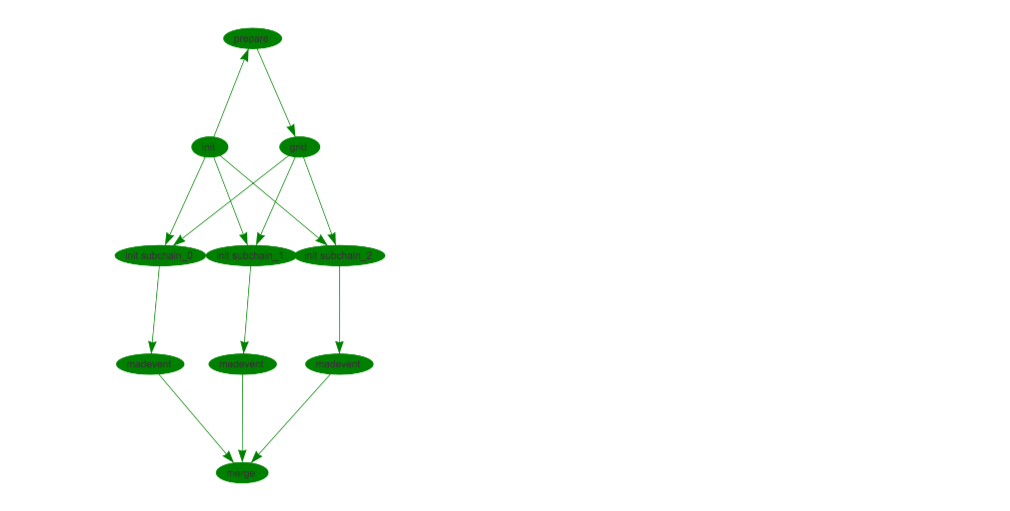

In [4]:
import yadage_widget
ui = yadage_widget.WorkflowWidget(wflow)
ui

One option is to run the workflow in *headless mode*, without any manual intervention

In [5]:
from adage import rundag
rundag(wflow, update_interval = 10, backend = backend,  additional_trackers=[ui.adagetracker])